In [19]:

import torch
import os

import numpy as np

from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import LoadImage, Resized, Compose, Lambda, LoadImaged, EnsureChannelFirstd
from monai.networks.nets import UNETR, UNet
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from monai.networks.layers import Norm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
dataset_list = []

# read all folders in Images

base_path = "./Task01_BrainTumour"


for file in os.listdir(os.path.join(base_path, "imagesTr")):

    data_dict = {
        "img": os.path.join(base_path, "imagesTr", file), 
        "seg": os.path.join(base_path, "labelsTr", file)
    }

    dataset_list.append(data_dict)

In [4]:
class BrainTumor(Dataset):

    def __init__(self, data, transform=None):
        super().__init__(data, transform)
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        element_dict = self.data[index]
        img_name = element_dict["img"]
        seg_name = element_dict["seg"]
        img = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(img_name)
        seg = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(seg_name)
        if self.transform:
            transformed = self.transform({"img": img, "seg": seg} )
            img = transformed["img"]
            seg = transformed["seg"]
            
        seg = seg.type(torch.LongTensor)
            
        return img, seg

In [5]:
test_img = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)("Task01_BrainTumour/imagesTr/BRATS_001.nii.gz") 

test_seg = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)("Task01_BrainTumour/labelsTr/BRATS_001.nii.gz")

print(test_img.shape, test_seg.shape)

torch.Size([4, 240, 240, 155]) torch.Size([1, 240, 240, 155])


In [6]:
# get the number of each value in test_seg
bins, hist = np.unique(test_seg.flatten(), return_counts=True) 
hist

array([8816276,   53050,   27189,   31485])

In [7]:
train_transforms = Compose([
    LoadImaged(keys=["img", "seg"]),
    EnsureChannelFirstd(keys=["img", "seg"]),
    #Lambda(lambda x: {"img": x["img"].permute(0, 3, 1, 2), "seg": x["seg"].permute(0, 3, 1, 2)}),
    Resized(keys=["img", "seg"], spatial_size=(64, 64, 32), mode=('nearest')),
    #ToTensorD(keys=["img", "seg"])
])

In [8]:
dataset = CacheDataset(data=dataset_list, transform=train_transforms, cache_rate=1.0, num_workers=12)
print(len(dataset))


train_dataset, test_dataset = torch.utils.data.random_split(dataset, [390, 94])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Loading dataset: 100%|████████████████████████████████████████████| 484/484 [01:06<00:00,  7.26it/s]

484


In [9]:
model = UNETR(
    in_channels=4,
    out_channels=4,
    img_size=(64, 64, 32),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=6,
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    conv_block=False,
).to(device)



In [10]:
def calculate_iou(predicted, target):
    """
    Calculate Intersection over Union (IoU) for binary segmentation.

    Args:
    - predicted (torch.Tensor): Predicted binary mask (0 or 1).
    - target (torch.Tensor): Ground truth binary mask (0 or 1).

    Returns:
    - float: IoU score.
    """
    intersection = torch.logical_and(predicted, target).sum().item()
    union = torch.logical_or(predicted, target).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [21]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True) #torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [23]:
num_epochs = 20
losses = []
test_losses = []
ious = []
test_ious = []
metric_values = []

for epoch in range(num_epochs):
    
    epoch_loss = 0
    epoch_test_loss = 0
    epoch_iou = 0
    epoch_test_iou = 0
    
    model.train() 
    
    for i, batch in enumerate(tqdm(train_dataloader)):
        
        img = batch["img"].to(device)
        seg = batch["seg"].to(device)
        
        optimizer.zero_grad()
        
        output = model(img)
        
        iou = calculate_iou(output, seg)
        ious.append(iou)
        
        loss = loss_function(output, seg)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    losses.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            
            img = batch["img"].to(device)
            seg = batch["seg"].to(device)
             
            output = model(img)
            
            iou = calculate_iou(output, seg)
            test_ious.append(iou)
            
            loss = loss_function(output, seg)
            
            epoch_test_loss += loss.item()
            dice_metric(y_pred=output, y=seg)
            
        metric = dice_metric.aggregate().item()
        dice_metric.reset()
        metric_values.append(metric)
            
        test_losses.append(epoch_test_loss)
        
        print(f"Epoch: {epoch} | Train Loss: {epoch_loss / len(train_dataloader)} | Test Loss: {epoch_test_loss / len(test_dataloader)} | Train IoU: {ious[-1]} | Test IoU: {test_ious[-1]} | current mean dice: {metric:.4f}")

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.181988184268658 | Test Loss: 1.1727205514907837 | Train IoU: 0.012111663818359375 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.1677848284061139 | Test Loss: 1.1594744523366292 | Train IoU: 0.014954884847005209 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 1.1553188012196467 | Test Loss: 1.1472535530726116 | Train IoU: 0.013884226481119791 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 1.14371513403379 | Test Loss: 1.1357804934183757 | Train IoU: 0.007986704508463541 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 1.1323015139653132 | Test Loss: 1.1245304743448894 | Train IoU: 0.01027679443359375 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 1.120907554259667 | Test Loss: 1.1136106650034587 | Train IoU: 0.006975809733072917 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 1.1102250997836773 | Test Loss: 1.1022284428278606 | Train IoU: 0.0116119384765625 | Test IoU: 0.012474569478007602 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 1.0984981977022612 | Test Loss: 1.0912956794102986 | Train IoU: 0.013029734293619791 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 1.088121432524461 | Test Loss: 1.0803440809249878 | Train IoU: 0.008509318033854166 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 1.0769488169596746 | Test Loss: 1.0700194040934246 | Train IoU: 0.012345631917317709 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 1.0666680244299083 | Test Loss: 1.060070554415385 | Train IoU: 0.010698954264322916 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 1.0568910195277288 | Test Loss: 1.0509608189264934 | Train IoU: 0.009695688883463541 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 1.0471514830222497 | Test Loss: 1.0406641960144043 | Train IoU: 0.012162526448567709 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 1.038431240962102 | Test Loss: 1.0330496629079182 | Train IoU: 0.009591420491536459 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 1.0279486912947435 | Test Loss: 1.0225034554799397 | Train IoU: 0.011182149251302084 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 1.0189137550500722 | Test Loss: 1.013749639193217 | Train IoU: 0.010019938151041666 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 1.0097991411502545 | Test Loss: 1.005456805229187 | Train IoU: 0.012045542399088541 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 1.0022209103290851 | Test Loss: 0.9981074134508768 | Train IoU: 0.009236653645833334 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.9930789929169875 | Test Loss: 0.9893989761670431 | Train IoU: 0.01248931884765625 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.9846523312421945 | Test Loss: 0.9831096529960632 | Train IoU: 0.013556162516276041 | Test IoU: 0.012474568684895833 | current mean dice: 0.2553


In [15]:
data = next(iter(train_dataloader))

data[0].shape

KeyError: 0

In [ ]:
np.unique(data[1][1], return_counts=True)

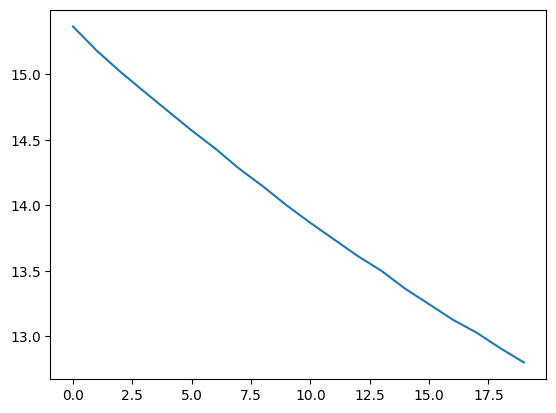

In [24]:
plt.plot(losses)

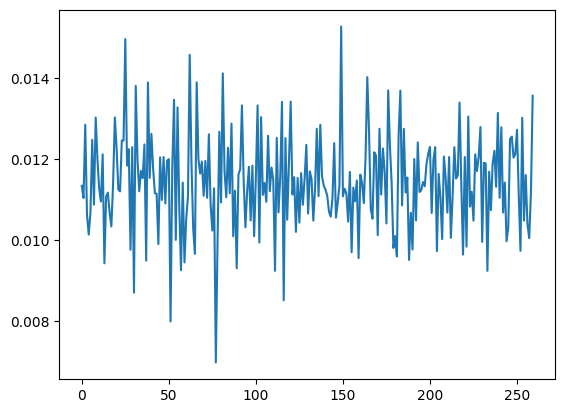

In [25]:
plt.plot(ious)

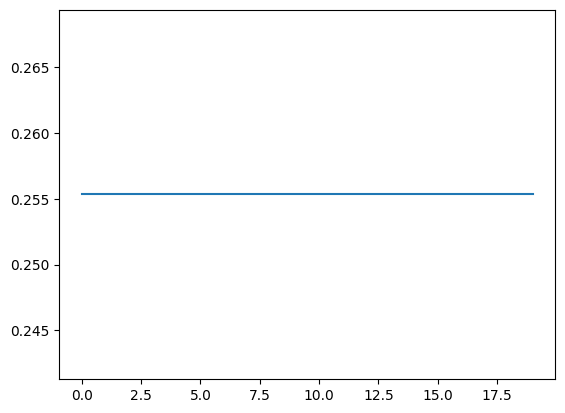

In [27]:
plt.plot(metric_values)